<h2>TrackPy parameterization script</h2>

This image-analysis script was used set determine the TrackPy parameters used in the chemotaxis assay and encounter rate enalayes. This script was developped within the framework of the following publication:

<em>de Schaetzen & Fan et al. Random encounters and predator locomotion drive the predation of Listeria monocytogenes by Acanthamoeba castellanii.</em>

<h4>Importing the required libraries and tools</h4>

In [1]:
from __future__ import division, unicode_literals, print_function  #for compatibility with Python 2 and 3
import os
import matplotlib.pyplot as plt
from tifffile import imread
from tifffile import imsave
import pims
import numpy as np
import trackpy as tp
import trackpy.predict
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral, denoise_wavelet, estimate_sigma)

<h3>TrackPy parameterization for CHEMOTAXIS ASSAY</h3>

The script block described below are only meant to be used in the analyses of the chemotaxis assay experiments. 
For the encounter rate experiments, you can find the appropriate TrackPy parameterization analyses below.

<h4>Defining folder variables for accessing files</h4>

The following folder structures should already have been created if you followed the steps in the ACLI_chemotaxis_assay  which can be found on the following GitHub repository: https://github.com/Renderfarm/Acanthamoeba-Listeria.



In [2]:
def_path = r'F:\Chemotaxis assay analysis\PAS_Rep3_13012021'#Set the default folder, the folder mentioned here only serves as an example
#the following definition allows for easy folder creation:
def createFolder(directory):    
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)
## TIFF, in this folder the converted video files will be saved (the conversion happens in ImageJ/Fiji)
TIFF_path = def_path + "\TIFF"
createFolder(TIFF_path)
## TIFFcor, in this folder the median background corrected and guassian blurred video files will be saved
TIFFcor_path = def_path + "\TIFFcor"
createFolder(TIFFcor_path)
## TIFFthres, in this folder the thresholded video files will be saved
TIFFthres_path = def_path + "\TIFFthres"
createFolder(TIFFthres_path)

<h4>The parameterization of the TrackPy plugin to localize particles/bacteria</h4>

More information about the parameterization can be found on the GitHub repository of the TrackPy team: http://soft-matter.github.io/trackpy/v0.5.0/

Once the parameters have been determined for one video of a given experiment, they can be kept constant for the other videos, assuming that no changes where made to the microscope (more specifically light intensity, magnification and exposure time) in between recordings!

<h5>Parameterization on 1 frame</h5>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026180729B88>,
      dtype=object)

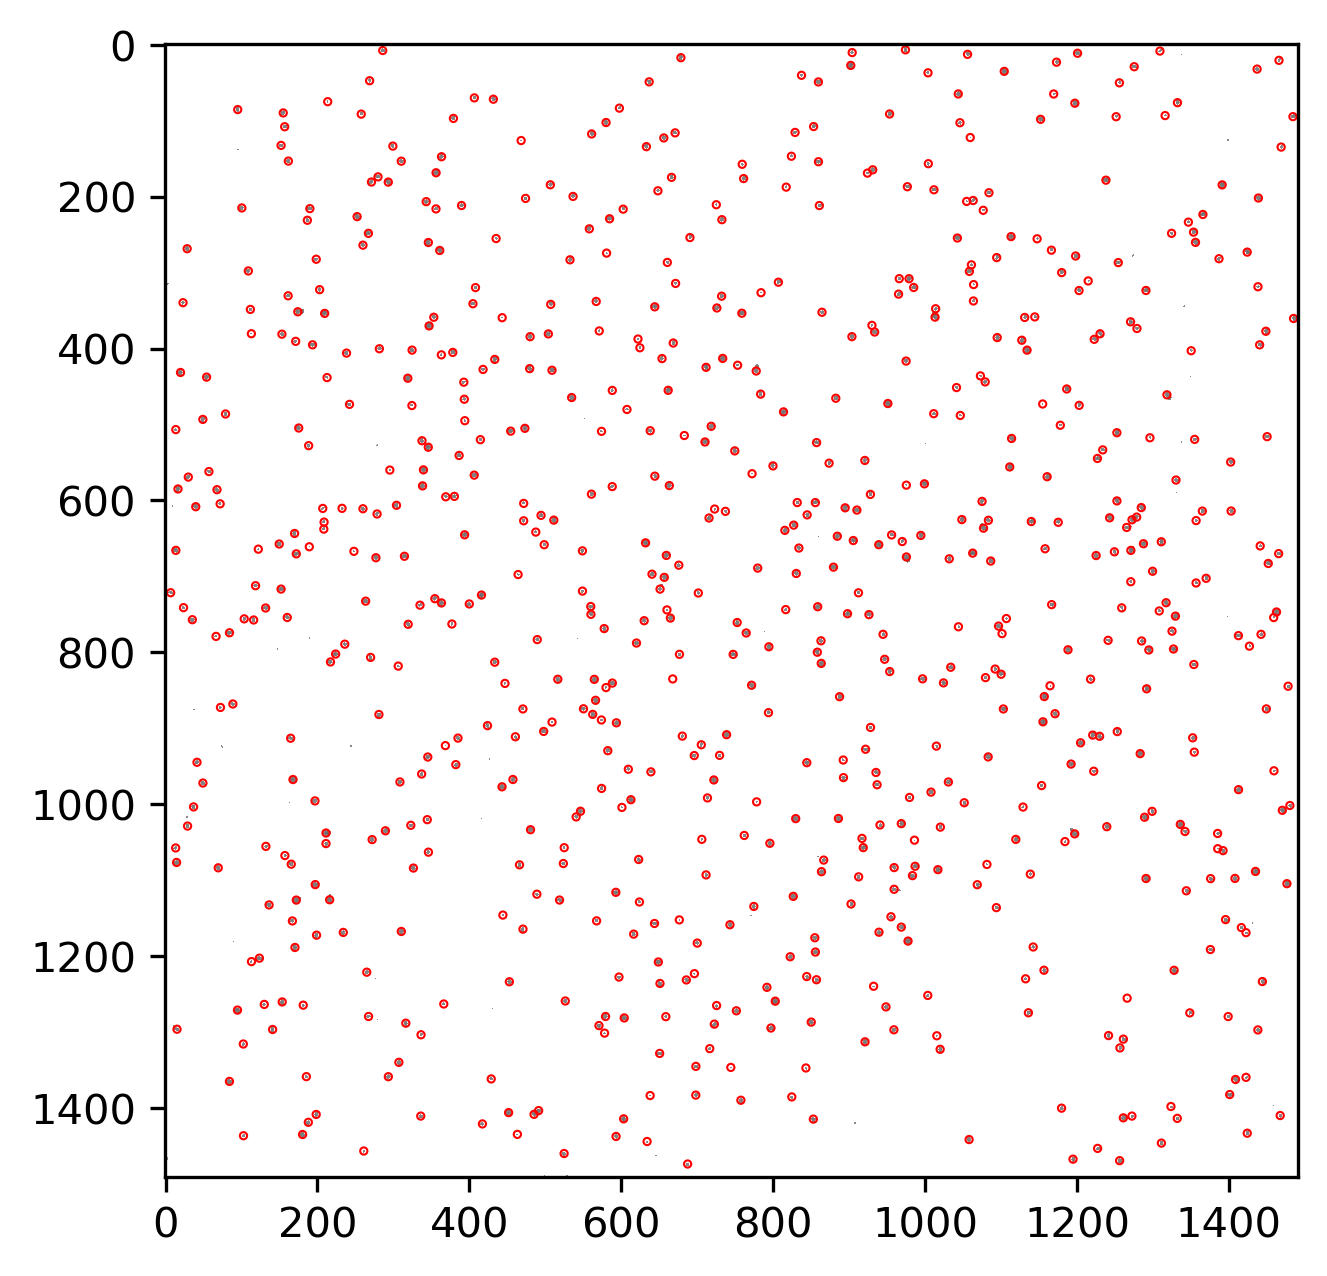

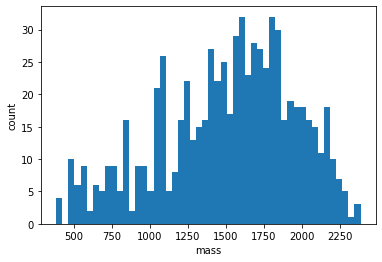

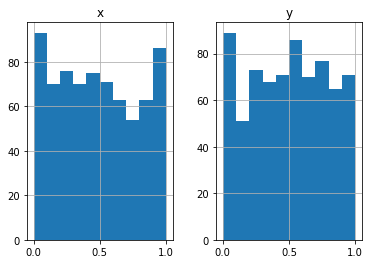

In [5]:
os.chdir(TIFFthres_path) # set the working directory to the TIFFthres folder
fl_TIFF = os.listdir(TIFFthres_path)
## Parameterisation of trackpy - the parameters below should be adjusted untill the best result has been achieved!
dia = 9 # diameter: approximate diameter (in pixels) of the particles to be located - this can be approximated in ImageJ
MinMass = 0 # Minimum mass: the minimum integrated brightness/darkness (filter to remove spurious objects)
Nsize = 1 # noise size: width of the gaussian blur filter to remove noise
Msize = 17 # maximum diameter size (in pixels) of the particles to be located
sep = 7 # minumum separation (in pixels) between two features
framenr = 10 # the frame number on which the parameterization will take place (frame 1 has a value of 0)
videonr = 3 # the video number on which the parameterization will take palce (video 1 (i.e. timepoint 1) has a value of 0)

## particle localization for 1 frame with the tp.locate function
frames = np.array(imread(fl_TIFF[videonr])) # import the video-file as a numpy array
fe = tp.locate(frames[framenr], diameter = dia, invert = True, noise_size = Nsize, minmass = MinMass, maxsize = Msize, separation = sep) 
plt.figure(figsize = (5,5), dpi = 300)  # make an empty plot
plt.scatter(fe['x'],fe['y'], s = 3, marker = 'o', edgecolors = 'r', facecolors = 'None', norm = True, linewidths = 0.5) # use the TrackPy scatter plot function
plt.imshow(frames[framenr], cmap = 'Greys_r' , vmin = 0, vmax = 255) # plot the frame on wich particles were located as a background 
## plot a histogram of the mass of the detected particles.
fig, ax = plt.subplots() # create and ampty plot
ax.hist(fe['mass'], bins=50) # plot a histrogram with binwidth of 50
ax.set(xlabel='mass', ylabel='count'); # set the axis labels
#Check for subpixel accuracy - the distribution of the decimal part of the x and/or y positions should be (close to) evenly distributed for the best results
tp.subpx_bias(fe) # a TrackPy function that makes a plot of the subpixel accuracy

<h5>Parameterization on multiple/all frames</h5>

Frame 124: 745 trajectories present.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000261D64A7C48>,
      dtype=object)

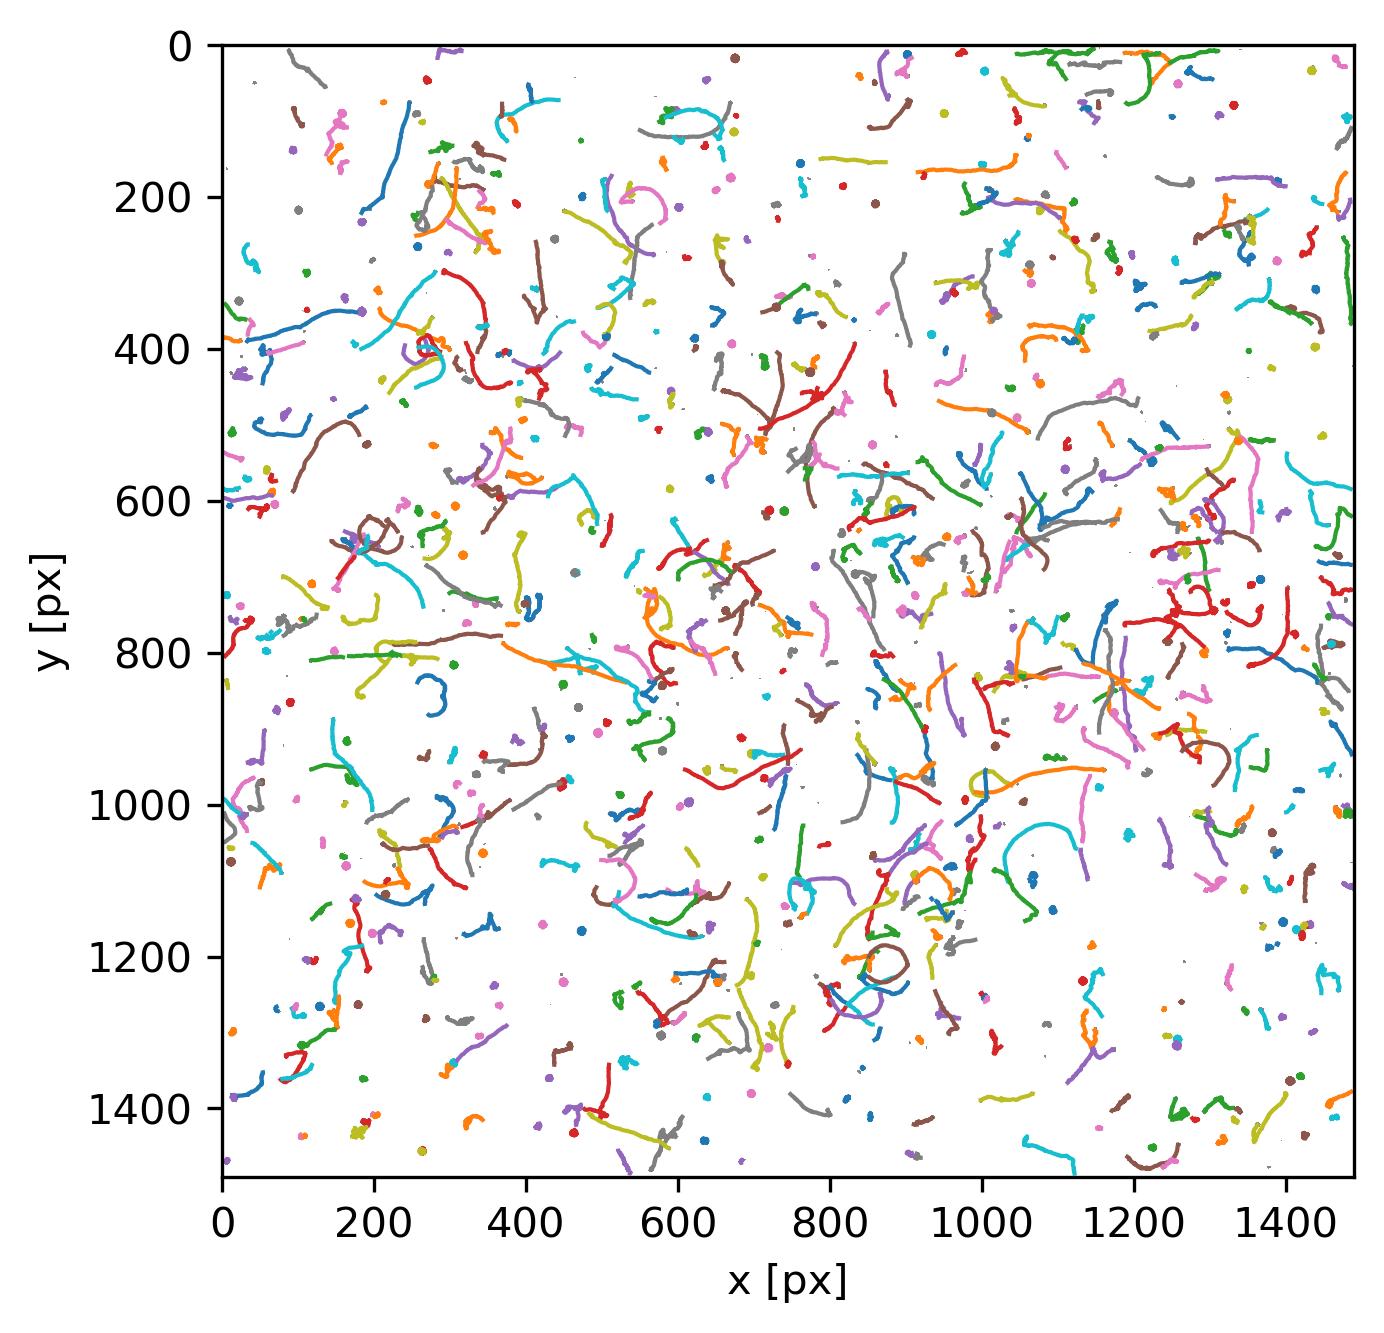

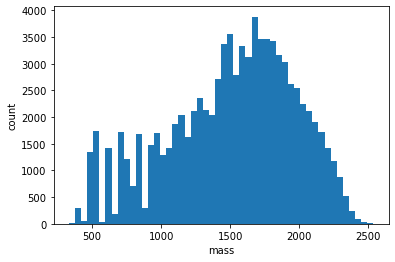

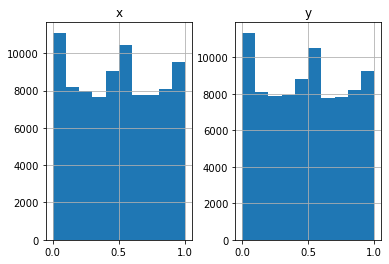

In [8]:
os.chdir(TIFFthres_path) # set the working directory to the TIFFthres folder
fl_TIFF = os.listdir(TIFFthres_path)
## parameters tp.locate() - change these untill optimized
dia = 9 # diameter: approximate diameter of the particles to be located
MinMass = 0 # the minimum integrated brightness
Nsize = 1 # noise size: width of the gaussian blur filter to remove noise
Pmem = 15 # particle memory: the maximum number of frames during which a feature can vanish, then reppear nearby, and be considered the same particle.
TrackTresh = 25 # minimum number of points frames for a trajectory to survive
MaxT = 5 # maximum amount of pixels a bacteria can move in between two consecutive frames
sep = 7 # minumum separation (in pixels) between two features
videonr = 3 # the video number on which the parameterization will take palce (video 1 (i.e. timepoint 1) has a value of 0)
## particle localization for all frames with the tp.batch function
frames = np.array(imread(fl_TIFF[videonr])) # import the video-file as a numpy array
fe = tp.batch(frames,  diameter = dia, invert = True, noise_size = Nsize, minmass = MinMass, separation = sep);
## link particles into trajectories with trackpy's predictive trajectory tracking
pred = trackpy.predict.NearestVelocityPredict() # determine which predictive trajectory functionality to use
t = pred.link_df(fe, search_range = MaxT, memory = Pmem) # use the predictive trajectory function of TrackPy
tf = tp.filter_stubs(t, TrackTresh) # filter out trajectories that are smaller that that 25 frames in length
## make a plot of the detected trajectories
plt.figure(figsize = (5,5), dpi = 300)# create and ampty plot
ax1 = plt.subplot(1,1,1) # add a new axis
tp.plot_traj(tf, ax=ax1,colorby = 'particle') # use the trajecotry  plot function
plt.imshow(frames[124], cmap = 'Greys_r' , vmin = 0, vmax = 255) # use one of the frames as a background image
## plot a histogram of the mass of the detected particles.
fig, ax = plt.subplots()# create and ampty plot
ax.hist(fe['mass'], bins=50) # plot a histrogram of the particles masses with binwidth of 50
ax.set(xlabel='mass', ylabel='count'); # set the axis labels
## Check for subpixel accuracy - the distribution of the decimal part of the x and/or y positions should be (close to) evenly distributed for the best results
tp.subpx_bias(f_b) # a TrackPy function that makes a plot of the subpixel accuracy